In [1]:
import time
import pickle
import random
from pathlib import Path
import pandas as pd
from typing import Literal
import tqdm
from functools import partial


import chess
import iceberg as ice
import matplotlib.pyplot as plt
import numpy as np
import torch
from leela_interp import Lc0Model, Lc0sight, LeelaBoard, ActivationCache
from leela_interp.core.iceberg_board import palette
from leela_interp.tools import figure_helpers as fh
from leela_interp.tools.probing import train_probes, eval_probe_top_k, eval_probe

In [2]:
import os
os.environ['PATH'] = "/Library/TeX/texbin:" + os.environ['PATH']
puzzles_second_movement = None

In [3]:
with open("../puzzles_with_move_trees_and_tags.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

12000

In [4]:
random_model = Lc0Model(onnx_model_path="../lc0-random.onnx", device="mps")
model = Lc0Model("../lc0.onnx", device="mps")

Using device: mps
Using device: mps


In [5]:
def get_activations(model, puzzles):
    activations = ActivationCache.capture(
        model=model,
        boards=[LeelaBoard.from_puzzle(p) for _, p in puzzles.iterrows()],
        # There's a typo in Lc0, so we mirror it; "rehape" is deliberate
        names=["attn_body/ma_gating/rehape2"]
        + [f"encoder{layer}/ln2" for layer in range(15)],
        n_samples=len(puzzles),
        # Uncomment to store activations on disk (they're about 70GB).
        # Without a path, they'll be kept in memory, which is faster but uses 70GB of RAM.
        #path="residual_activations.zarr",
        overwrite=True,
        store_boards=True,
        batch_size = 128,
    )
    return activations

In [6]:
threshold = puzzles["effects_010_tgt"].quantile(0.7)
other_puzzles = puzzles[puzzles["effects_010_tgt"] > 0]
threshold_2 = other_puzzles["effects_00000_tgt"].quantile(0.7)
#other_puzzles = other_puzzles[other_puzzles["effects_00000_tgt"] > 0]
other_puzzles = other_puzzles[other_puzzles["move_tree"].apply(lambda x: "010" in x and "00000" in x and x["00000"][2:4] != x["010"][2:4])]
print(f"Len puzzles: {len(other_puzzles)}")

Len puzzles: 2097


In [7]:
other_puzzles = other_puzzles[:2050]
other_puzzles = puzzles[:5050]
n_train = 3500

t0 = time.time()
activations = get_activations(model, other_puzzles)
print(f"Captured  n = {len(other_puzzles)} activations in {time.time() - t0:.1f}s")

100%|██████████| 40/40 [01:03<00:00,  1.59s/it]

Captured  n = 5050 activations in 63.9s


In [8]:
def collect_data(
    puzzles: pd.DataFrame,
    activations: ActivationCache,
    activation_name: str,
    prediction_target: Literal["target", "source"],
    n_train: int,
    train=True,
    move1 = "000",
    move2 = "0",
):
    ys = []
    z_squares = []
    if train:
        boards = activations.boards[:n_train]
        puzzles = puzzles.iloc[:n_train]
    else:
        boards = activations.boards[n_train:]
        puzzles = puzzles.iloc[n_train:]
    idxs = []

    for i, (board, (_, puzzle)) in enumerate(zip(boards, puzzles.iterrows())):
        assert board.fen() == LeelaBoard.from_puzzle(puzzle).fen()
        if puzzle.move_tree.get(move1, None) is None or puzzle.move_tree.get(move2, None) is None:
            continue
        idxs.append(i)
        if prediction_target == "target":
            y = puzzle.move_tree.get(move1)[2:4]
            z = puzzle.move_tree.get(move2)[2:4]
        elif prediction_target == "source":
            y = puzzle.move_tree.get(move1)[:2]
            z = puzzle.move_tree.get(move1)[2:4]
        ys.append(board.sq2idx(y))
        z_squares.append(board.sq2idx(z))

    if train:
        X = activations[activation_name][:n_train][idxs]
    else:
        X = activations[activation_name][n_train:][idxs]
    assert X.shape[1:] == (64, 768), X.shape

    ys = np.array(ys)
    z_squares = np.array(z_squares)

    return X, ys, z_squares

collect_data_1 = partial(collect_data, move1="000", move2="0")
collect_data_2 = partial(collect_data, move1="100", move2="1")

In [9]:
hparams = {
    "n_epochs": 5,
    "lr": 1e-2,
    "weight_decay": 0,
    "k": 32,
    "batch_size": 64,
    "device": "mps",
}

In [10]:
def eval_probes(target_probes, source_probes, puzzles, activations, n_train, path, collect_data_fn):
    accuracies = []
    source_accuracies = []
    target_accuracies = []
    
    for layer, target_probe, source_probe in zip(
        tqdm.trange(15), target_probes, source_probes
    ):
        name = f"encoder{layer}/ln2"
        source_accuracy, target_accuracy, accuracy = eval_probe(
            target_probe, source_probe, puzzles, activations, name, n_train, collect_data_fn)
        
        accuracies.append(accuracy)
        source_accuracies.append(source_accuracy)
        target_accuracies.append(target_accuracy)
    
    results_dict = {
        "accuracies": np.array(accuracies),
        "source_accuracies": np.array(source_accuracies),
        "target_accuracies": np.array(target_accuracies),
    }
    
    if path is not None:
        with open(path, "wb") as f:
            pickle.dump(results_dict, f)
    
    return results_dict

def eval_probes_top_k(target_probes, source_probes, puzzles, activations, n_train, path, collect_data_fn, k=1):
    accuracies = []
    source_accuracies = []
    target_accuracies = []
    accuracies_top_k = []
    source_accuracies_top_k = []
    target_accuracies_top_k = []
    
    for layer, target_probe, source_probe in zip(
        tqdm.trange(15), target_probes, source_probes
    ):
        name = f"encoder{layer}/ln2"
        results = eval_probe_top_k(
            target_probe, source_probe, puzzles, activations, name, n_train, collect_data_fn, k)
        
        accuracies.append(results['accuracy'])
        source_accuracies.append(results['source_accuracy'])
        target_accuracies.append(results['target_accuracy'])
        accuracies_top_k.append(results['accuracy_top_k'])
        source_accuracies_top_k.append(results['source_accuracy_top_k'])
        target_accuracies_top_k.append(results['target_accuracy_top_k'])
    
    results_dict = {
        "accuracies": np.array(accuracies_top_k),
        "source_accuracies": np.array(source_accuracies_top_k),
        "target_accuracies": np.array(target_accuracies_top_k),
    }
    
    if path is not None:
        with open(path, "wb") as f:
            pickle.dump(results_dict, f)
    
    return results_dict

In [11]:
t0 = time.time()
target_probes, source_probes = train_probes(
    activations, other_puzzles, n_train, hparams, collect_data_1
)
print(f"Training took {time.time() - t0:.2f}s")
results_main_1 = eval_probes_top_k(target_probes, source_probes, other_puzzles, activations, n_train, None, collect_data_1)
print(f"total time: {time.time() - t0:.2f}s")

results_main_2 = eval_probes_top_k(target_probes, source_probes, other_puzzles, activations, n_train, None, collect_data_2)

target_probes_2, source_probes_2 = train_probes(
    activations, other_puzzles, n_train, hparams, collect_data_2
)

results_main_3 = eval_probes_top_k(target_probes_2, source_probes_2, other_puzzles, activations, n_train, None, collect_data_2)

results_main_4 = eval_probes_top_k(target_probes_2, source_probes_2, other_puzzles, activations, n_train, None, collect_data_1)


Training took 38.70s


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


total time: 48.73s


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


In [12]:
del activations

In [13]:
activations_random = get_activations(random_model, other_puzzles)

100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


In [14]:
target_probes_random, source_probes_random = train_probes(activations_random, other_puzzles, n_train, hparams, collect_data_1)
results_random_1 = eval_probes_top_k(target_probes_random, source_probes_random, other_puzzles, activations_random, n_train, None, collect_data_1)

results_random_2 = eval_probes_top_k(target_probes_random, source_probes_random, other_puzzles, activations_random, n_train, None, collect_data_2)

target_probes_random_2, source_probes_random_2 = train_probes(activations_random, other_puzzles, n_train, hparams, collect_data_2)
results_random_3 = eval_probes_top_k(target_probes_random_2, source_probes_random_2, other_puzzles, activations_random, n_train, None, collect_data_2)
results_random_4 = eval_probes_top_k(target_probes_random_2, source_probes_random_2, other_puzzles, activations_random, n_train, None, collect_data_1)

100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


In [15]:
del activations_random

In [16]:
SETTING_TO_PRETTY_NAME = {
    "main": "Probe on trained model",
    "random_model": "Probe on random model",
}


def plot_probe_results(results_main, results_random_model, split="all", title="Third move prediction", save_path=None):
    fh.set(fast=False)
    fig, ax = plt.subplots(figsize=(fh.HALF_WIDTH, 2))
    for i, setting in enumerate(["main", "random_model"]):
        results = np.zeros((15, 5))
        for j in range(5):
            if setting == "main":
                results[:,j] = results_main["accuracies"]
            elif setting == "random_model":
                results[:,j] = results_random_model["accuracies"]
        
        means = results.mean(1)
        squared_seed_errors = results.var(1) / results.shape[1]
        # Size of the eval dataset is 30% of all puzzles
        squared_acc_errors = means * (1 - means) / (0.3 * len(puzzles))
        # 2 sigma errors
        errors = 2 * np.sqrt(squared_seed_errors + squared_acc_errors)
        max_layer = means.argmax()
        print(
            f"Max accuracy ({setting}, L{max_layer}): {means[max_layer]:.2f} +- {errors[max_layer]:.2f}"
        )
        ax.plot(
            means,
            label=SETTING_TO_PRETTY_NAME[setting],
            color=fh.COLORS[i],
            linewidth=fh.LINE_WIDTH,
        )
        ax.fill_between(
            range(15),
            means - errors,
            means + errors,
            color=fh.COLORS[i],
            alpha=fh.ERROR_ALPHA,
            linewidth=0,
        )
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.set_ylim(0, 1.0)
    ax.set_xlim(0, 14)
    ax.spines[:].set_visible(False)
    ax.set_facecolor(fh.PLOT_FACE_COLOR)
    ax.grid(linestyle="--")
    ax.grid(which="minor", alpha=0.3, linestyle="--")

    if save_path is not None:
        fh.save(save_path, fig)
    
    return fig, ax

Max accuracy (main, L12): 0.84 +- 0.01
Max accuracy (random_model, L9): 0.20 +- 0.01


(<Figure size 258.55x200 with 1 Axes>,
 <Axes: title={'center': 'Fifth move prediction'}, xlabel='Layer', ylabel='Accuracy'>)

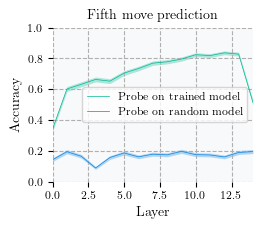

In [17]:
plot_probe_results(results_main=results_main_1, results_random_model=results_random_1, title="Fifth move prediction")

Max accuracy (main, L13): 0.08 +- 0.01
Max accuracy (random_model, L6): 0.01 +- 0.00


(<Figure size 258.55x200 with 1 Axes>,
 <Axes: title={'center': 'Fourth move prediction'}, xlabel='Layer', ylabel='Accuracy'>)

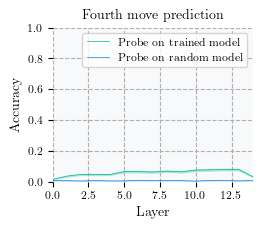

In [18]:
plot_probe_results(results_main=results_main_2, results_random_model=results_random_2, title="Fourth move prediction")

Max accuracy (main, L13): 0.24 +- 0.01
Max accuracy (random_model, L12): 0.01 +- 0.00


(<Figure size 258.55x200 with 1 Axes>,
 <Axes: title={'center': 'Alternative third move prediction'}, xlabel='Layer', ylabel='Accuracy'>)

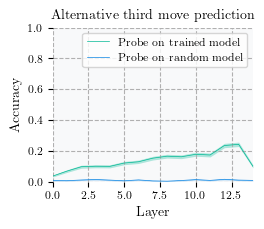

In [19]:
plot_probe_results(results_main=results_main_3, results_random_model=results_random_3, title="100 - Alternative third move prediction", save_path="100_alternative_third_move_prediction")

Max accuracy (main, L11): 0.28 +- 0.01
Max accuracy (random_model, L9): 0.01 +- 0.00


(<Figure size 258.55x200 with 1 Axes>,
 <Axes: title={'center': 'Third move prediction'}, xlabel='Layer', ylabel='Accuracy'>)

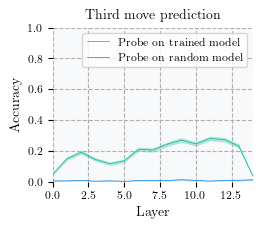

In [20]:
plot_probe_results(results_main=results_main_4, results_random_model=results_random_4, title="100 probe, 000 evaluation", save_path="100_probe_000_evaluation.png")

In [21]:
print(f"caramelitodromo")

caramelitodromo
